---
>「人は手ではなく脳で絵を描く。」
>
> ミケランジェロ
---

# Text2imageのパーソナライズ化

強力なText-to-imageモデルではあるが、例えば「自分の飼っている猫を入れた画像を生成したい」といった、特定のユニークな概念の画像を生成したり、その外観を変更したり、新しい役割や新規のシーンに合成したりすることはできれば、さらに利用価値が高まる

ここでは、オブジェクトやスタイルなど、利用者が提供した3-5枚の画像のみ使い、構築済みのテキスト-画像モデル変換モデルにおける潜在空間に新しい「言葉」を使って表現できるように学習させる

- つまり、新しいスタイルとしてのオブジェクトを含む画像を提示し、そこにあるオブジェクトに新たな「名前」を与えておくことで、その「名前」を用いて画像を生成することで、そのオブジェクトを含む画像を生成させる

- この「言葉」は、自然言語文として構成することができるため、直感的な方法で所望の画像を生成させることができる


## LoRA（Low-Rank Adaptation）とは

LoRA（Low-Rank Adaptation）は、既存のStable Diffusionモデルを20枚程度の画像を用いて追加学習させることにより微調整することができる仕組み

LoRAを用いることにより、キャラクターや服装などの特徴を固定して画像生成することができるようになる

学習および生成には次のような注意点がある

- 初期化語はオブジェクトを説明する単語、例えば、toy、picture、scruptureなどとすること
  - 入力が単語出ない場合は、再入力となる
- ここではepochを5千としているが、通常はより速く収束する
- エンベッディングと出力画像はlogディレクトリに保存される
- 概念を表すプレースホルダーの変更（デフォルトは "*"）、学習反復の最大回数の変更、チェックポイントの保存頻度の変更など、その他のオプションは configs/latent-diffusion/txt2img-1p4B-finetune.yaml を参照すること
- トレーニングセットの画像はすべて正立させておくこと
  - 特に、スマートフォンで撮影した画像は、画像自体が倒立しており、表示の際に正立させる場合も多く、このままでは利用できない
- プロンプトに "a photo of "を追加すると、対象となる生成画像の一貫性がより良くなるので、利用するとよい
- 結果は乱数のシードの影響を受けるため、結果に満足できない場合は、新しいシードで生成するとよい


生成結果の例

左の画像にあるオブジェクトに`S*`という名前を付け、これを用いて生成させた例を示す
- この例をみれば、何がしたいのかがわかるであろう

![](http://class.west.sd.keio.ac.jp/dataai/text/teaser.jpg)

![](http://class.west.sd.keio.ac.jp/dataai/text/diffusionsamples.jpg)

![](http://class.west.sd.keio.ac.jp/dataai/text/diffusionstyle.jpg)

## 関連用語整理

### 転移学習

解いた設問の解法を別の設問に応用する場合において、**データセットの量が不十分**なうえで、精度の高いモデルを獲得する手法

既存の学習済みモデルを別の目的のモデルとして利用するために、ネットワークの一部を変更したりしつつ、学習済みパラメータをもとに、新たに追加したモデルのデータのみ学習させる

### ファインチューニング

新たに学習するデータセットが多いケースでは、転移学習をそのまま行うとかえって時間がかかる可能性があるため、一度解いた設問の解法を別の設問のために微調整する手法

**データセットの量が十分**にあることが前提としてあり、モデル全体のデータを再学習することで、汎化性能をより向上させる

### 蒸留

学習済みモデルを使用して、より軽量なモデルを生み出す手法

学習済みモデルを教師モデルとして、その出力を生徒モデルの学習に利用する
- 教師モデルから生徒モデル間の損失を「ソフトターゲットロス」、生徒モデルの学習データの正解ラベルを「ハードターゲット」、その損失を「ハードターゲットロス」と呼ぶ
- ラベル付きデータを利用する場合はこれら2種類のターゲットロスを用い、ラベルなしのデータを利用する場合はソフトターゲットロスのみを用いて学習を行う

### Few-shot Learning（フューショット学習）

画像生成モデルやChatGPTなどの巨大言語モデルにおいて、ファインチューニングすることなく、少数の例文を文脈の中で提示するだけで、さまざまなタスクを達成できるように、少量のデータを与えることで求める結果を得る手法

言語モデルのパラメータは更新せず、少数の例文を文脈の中でデモンストレーションとして提示することで、さまざまなタスクを解決する能力を持たせることができる

特に、例文・見本が1つだけの場合「ワンショット学習（One-shot learning）」、例文がない場合「ゼロショット学習（Zero-shot Learning）」と呼ぶ

これらについては、ChatGPTでより詳しく触れる

### 事前学習

関連する新たな目的に利用するため、あらかじめ大量のデータセットで学習させたモデルを構築すること

この事前学習モデルは、新たなタスクへの転移学習やファインチューニングの基盤モデルとなる

### マルチタスク学習

複数の関連するタスクを同時に学習する手法



ここでは、数枚の画像を用いて再学習してモデルパラメータを更新させるため、few-shotファインチューニングといえる

では早速ためしてみよう

Colabでは全体の実行に、およそ30分程度必要である

## 環境セットアップ

ライブラリをインストール

In [1]:
!pip install -qq git+https://github.com/huggingface/diffusers.git accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes
!pip install omegaconf
!pip install bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 136.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:0

改めてHugging Faceログインを行う
- 先に用いた登録済トークンを入力する
- ここでは、既に入力されていることを前提とし、コメントアウトしている

In [2]:
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

ライブラリをインポートする

In [3]:
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset
import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
#from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import bitsandbytes as bnb

画像表示関数を定義する

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## 学習済モデル・追加学習画像のセットアップと学習

事前学習済みモデルを登録する

特に修正の必要はないが、他のモデルを試すこともできる



In [5]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

スタイル画像を指定する
- 5枚程度でよい

In [6]:
urls = [
    'https://1.bp.blogspot.com/-JLT7FAbMiF4/X3hGHAgEHjI/AAAAAAABboc/OWpiTz5HLHg9A1b5tK7RVz1orj2H0XKvwCNcBGAsYHQ/s250/penlight_man01_blue.png',
    'https://1.bp.blogspot.com/-qrkLCElBrZU/X3hGIGBcv0I/AAAAAAABbos/uumBDo0U7TgnTwvhbqMWEWSlqeA3kuNVACNcBGAsYHQ/s250/penlight_man05_orange.png',
    'https://1.bp.blogspot.com/-TPcG8H-94Q8/XAnwX_0l2FI/AAAAAAABQw4/wJI0CD-SxO4UWBm8YVegxlls031mKKqzgCLcBGAs/s330/stand_naname1_boy.png',
    'https://4.bp.blogspot.com/-ld3QWamGpWI/XAnwYQ4RPeI/AAAAAAABQw8/AcQhuWaS_CAFHfINOJDm3wxmFG57AhmFgCLcBGAs/s380/stand_naname2_school_boy.png',
    'https://1.bp.blogspot.com/-LgVrdZ34XRM/XAnwY68nMrI/AAAAAAABQxA/P71YbDy3z3YCWiX9rLRsPQPw0iUzevxGwCLcBGAs/s400/stand_naname3_man.png',
    'https://1.bp.blogspot.com/-598mkkGFaD8/XAnwZDh48DI/AAAAAAABQxE/y-rIs9aaPQMVaYIuM_LaY2Q1HJojNIT0wCLcBGAs/s400/stand_naname4_businessman.png'
          ]

指定したスタイル画像を確認する
- ここでは、いらすとやの画像を用いて、いらすとや風の画像を自由に生成させよう

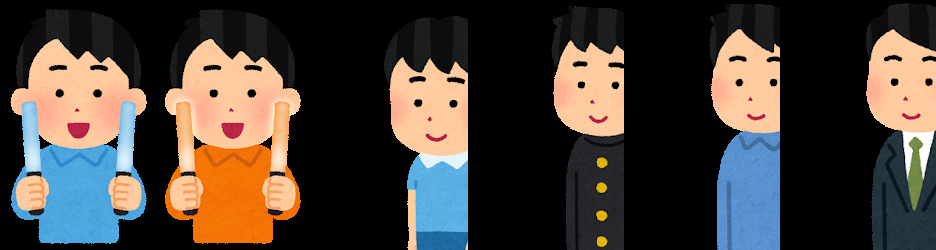

In [7]:
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)

[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

学習の準備を行う

- まず、オブジェクトや画風の説明を行う
- ここをどのように与えるかで最終生成画像の質が変わる
- 試しに独自の画像をしているする場合は、ここで指定している`instance_prompt`および`prior_preservation_class_prompt`を参考にして各自指定すること

In [8]:
# オブジェクト、画風の説明
instance_prompt = " an illustration of sks boy" #@param {type:"string"}

# コンセプトクラスの指定、画質が向上
prior_preservation = False #@param {type:"boolean"}
prior_preservation_class_prompt = " an illustration of a boy" #@param {type:"string"}

num_class_images = 12
sample_batch_size = 2
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt

事前保存のための高度な設定を行う
- 特に修正の必要はない

In [9]:
num_class_images = 12
sample_batch_size = 2
prior_loss_weight = 1

prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder

DreamBoothデータセットとプロンプトデータセットのクラスを定義する

In [10]:
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

コンセプトクラスが指定されている場合、その設定を行う

In [11]:
import gc
if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, use_auth_token=True, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            with torch.autocast("cuda"):
                images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

In [12]:
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

In [13]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder",
    use_auth_token='true'
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae",
    use_auth_token='true'
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet",
    use_auth_token='true'
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_auth_token='true'
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:3101: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2027: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

各種ハイパーパラメータを指定する
- ここで乱数のシードも変更できる

In [14]:
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=512,
    center_crop=True,
    instance_data_dir=save_path,
    instance_prompt=instance_prompt,
    learning_rate=5e-06,
    max_train_steps=450,
    train_batch_size=1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="no", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation,
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder,
    class_prompt=prior_preservation_class_prompt,
    num_class_images=num_class_images,
    output_dir="dreambooth-concept",
)

学習用の関数を定義する

In [15]:
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )

    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    noise, noise_prior = torch.chunk(noise, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior, noise_prior, reduction="none").mean([1, 2, 3]).mean()

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(args.output_dir)

## 訓練

実際に訓練を行う

30分弱程度必要である

In [16]:
import accelerate
accelerate.notebook_launcher(training_function, num_processes=1, args=(text_encoder, vae, unet))
with torch.no_grad():
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/450 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:201: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.31.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have 

## 推論

画像を生成させる

同じ学習済みモデルを用いて再度生成する場合は、この下のセルを再実行すること

In [17]:
pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        torch_dtype=torch.float16,
    ).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

オブジェクトに「いらすとや」の画像を用いたので、いらすとや風の画像を生成できるようになる

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

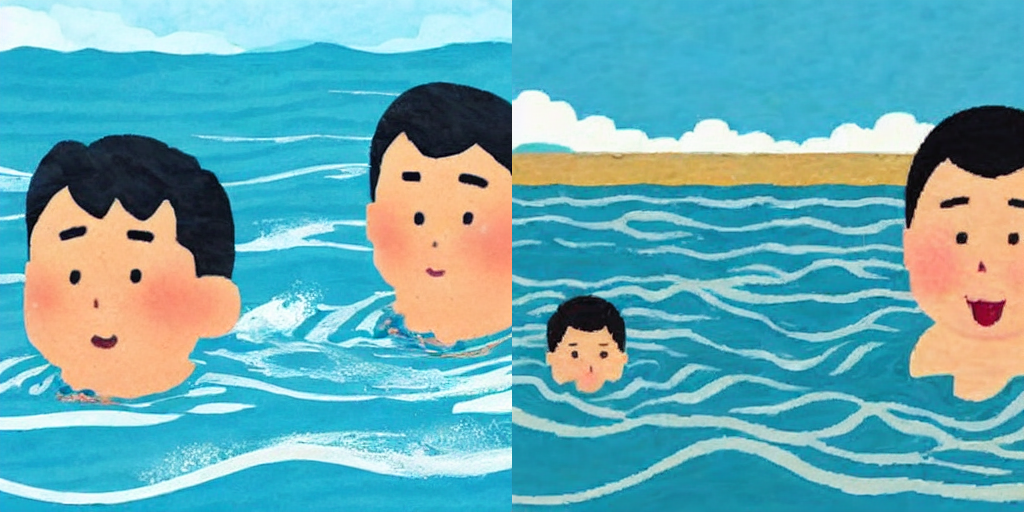

In [18]:
from torch import autocast
prompt = " an real illustration of sks boy swimming sea" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    with autocast("cuda"):
        images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
        all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

# チェックポイント

一度ここで中断し、次のセルから再度実行すること

In [19]:
#from google.colab import runtime
#runtime.unassign()

# 課題

Dearmboothやその他LoRAについて調査し、別途準備したサンプル画像をもとに画像を生成してみよう

# Deforum Stable Diffusion

テキストから動画を作成する
- オリジナルと異なり、Google Driveのマウントなしに実行するように変更
- デフォルト設定も変更

## サブプロセスの導入

別の処理をPython内部で実行させるためのライブラリ

"!"コマンドがあるので、基本的に不要ではあるが、オリジナルに従ってサブプロセスを利用する


In [20]:
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15360 MiB, 6999 MiB



## モデルのダウンロードと展開

かなり大きいため、これだけで7分程度必要

In [21]:
import os
if not os.path.exists('sd-v1-4.zip'):
  #!wget "https://drive.google.com/uc?export=download&id=12KllqHeJqK-Wf_AdANIAbN0iej_1AdR3" -O sd-v1-4.zip
  !wget https://keio.box.com/shared/static/w4eom6h7v7y01k7xuj67hdm9p4wlg00w -O sd-v1-4.zip
  !unzip sd-v1-4.zip

--2024-08-21 10:51:44--  https://keio.box.com/shared/static/w4eom6h7v7y01k7xuj67hdm9p4wlg00w
Resolving keio.box.com (keio.box.com)... 74.112.186.157
Connecting to keio.box.com (keio.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/w4eom6h7v7y01k7xuj67hdm9p4wlg00w [following]
--2024-08-21 10:51:44--  https://keio.box.com/public/static/w4eom6h7v7y01k7xuj67hdm9p4wlg00w
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/w4eom6h7v7y01k7xuj67hdm9p4wlg00w [following]
--2024-08-21 10:51:45--  https://keio.app.box.com/public/static/w4eom6h7v7y01k7xuj67hdm9p4wlg00w
Resolving keio.app.box.com (keio.app.box.com)... 74.112.186.157
Connecting to keio.app.box.com (keio.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!KBr-4

## 各種パスを設定

In [22]:
models_path = "/content/"
output_path = "/content/output"

drive_path = "/content/"
models_path = "/content/"
output_path = "/content/DSD/StableDiffusion"

In [23]:
import os
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

## 環境の構築

In [24]:
import subprocess, time
print("Setting up environment...")
start_time = time.time()
all_process = [
    ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
    ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'kornia==0.6.7'],
    ['git', 'clone', 'https://github.com/deforum/stable-diffusion'],
    ['pip', 'install', '-e', 'git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers'],
    ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
    ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq'],
    ['git', 'clone', 'https://github.com/shariqfarooq123/AdaBins.git'],
    ['git', 'clone', 'https://github.com/isl-org/MiDaS.git'],
    ['git', 'clone', 'https://github.com/MSFTserver/pytorch3d-lite.git'],
]
for process in all_process:
    running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(running)

Setting up environment...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 453.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1+cu121
    Uninstalling torch-2.3.1+cu121:
      Successfully uninstalled torch-2.3.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1+cu121
    Uninstalling torchvision-0.18.1+cu121:
      Successfully uninstalled torchvision-0.18.1+cu121



Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-transformers
  Resolved https://github.com/CompVis/taming-transformers.git to commit 3ba01b241669f5ade541ce990f7650a3b8f65318
  Preparing metadata (

In [25]:
print(subprocess.run(['git', 'clone', 'https://github.com/crowsonkb/k-diffusion/'], stdout=subprocess.PIPE).stdout.decode('utf-8'))
with open('k-diffusion/k_diffusion/__init__.py', 'w') as f:
    f.write('')

end_time = time.time()
print(f"Environment set up in {end_time-start_time:.0f} seconds")


Environment set up in 195 seconds


## ライブラリの導入とヘルパー関数の定義

In [1]:
!pip install pytorch-lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [26]:
import json
from IPython import display

import math, os, pathlib, shutil, subprocess, sys, time
import cv2
import numpy as np
import pandas as pd
import random
import requests
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from skimage.exposure import match_histograms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from types import SimpleNamespace
from torch import autocast

sys.path.extend([
    'src/taming-transformers',
    'src/clip',
    'stable-diffusion/',
    'k-diffusion',
    'pytorch3d-lite',
    'AdaBins',
    'MiDaS',
])

import py3d_tools as p3d

from helpers import save_samples, sampler_fn
from infer import InferenceHelper
from k_diffusion import sampling
from k_diffusion.external import CompVisDenoiser
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from midas.dpt_depth import DPTDepthModel
from midas.transforms import Resize, NormalizeImage, PrepareForNet

ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
def sanitize(prompt):
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    tmp = ''.join(filter(whitelist.__contains__, prompt))
    return '_'.join(prompt.split(" "))

def anim_frame_warp_2d(prev_img_cv2, args, anim_args, keys, frame_idx):
    angle = keys.angle_series[frame_idx]
    zoom = keys.zoom_series[frame_idx]
    translation_x = keys.translation_x_series[frame_idx]
    translation_y = keys.translation_y_series[frame_idx]

    center = (args.W // 2, args.H // 2)
    trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    rot_mat = cv2.getRotationMatrix2D(center, angle, zoom)
    trans_mat = np.vstack([trans_mat, [0,0,1]])
    rot_mat = np.vstack([rot_mat, [0,0,1]])
    xform = np.matmul(rot_mat, trans_mat)

    return cv2.warpPerspective(
        prev_img_cv2,
        xform,
        (prev_img_cv2.shape[1], prev_img_cv2.shape[0]),
        borderMode=cv2.BORDER_WRAP if anim_args.border == 'wrap' else cv2.BORDER_REPLICATE
    )

def anim_frame_warp_3d(prev_img_cv2, anim_args, keys, frame_idx, adabins_helper, midas_model, midas_transform):
    TRANSLATION_SCALE = 1.0/200.0 # matches Disco
    translate_xyz = [
        -keys.translation_x_series[frame_idx] * TRANSLATION_SCALE,
        keys.translation_y_series[frame_idx] * TRANSLATION_SCALE,
        -keys.translation_z_series[frame_idx] * TRANSLATION_SCALE
    ]
    rotate_xyz = [
        math.radians(keys.rotation_3d_x_series[frame_idx]),
        math.radians(keys.rotation_3d_y_series[frame_idx]),
        math.radians(keys.rotation_3d_z_series[frame_idx])
    ]
    rot_mat = p3d.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
    result = transform_image_3d(prev_img_cv2, adabins_helper, midas_model, midas_transform, rot_mat, translate_xyz, anim_args)
    torch.cuda.empty_cache()
    return result

def add_noise(sample: torch.Tensor, noise_amt: float):
    return sample + torch.randn(sample.shape, device=sample.device) * noise_amt

def download_depth_models():
    def wget(url, outputdir):
        print(subprocess.run(['wget', url, '-P', outputdir], stdout=subprocess.PIPE).stdout.decode('utf-8'))
    if not os.path.exists(os.path.join(models_path, 'dpt_large-midas-2f21e586.pt')):
        print("Downloading dpt_large-midas-2f21e586.pt...")
        wget("https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt", models_path)
    if not os.path.exists('pretrained/AdaBins_nyu.pt'):
        print("Downloading AdaBins_nyu.pt...")
        os.makedirs('pretrained', exist_ok=True)
        wget("https://cloudflare-ipfs.com/ipfs/Qmd2mMnDLWePKmgfS8m6ntAg4nhV5VkUyAydYBp8cWWeB7/AdaBins_nyu.pt", 'pretrained')

def get_output_folder(output_path, batch_folder):
    out_path = os.path.join(output_path,time.strftime('%Y-%m'))
    if batch_folder != "":
        out_path = os.path.join(out_path, batch_folder)
    os.makedirs(out_path, exist_ok=True)
    return out_path

def load_depth_model(optimize=True):
    midas_model = DPTDepthModel(
        path=f"{models_path}/dpt_large-midas-2f21e586.pt",
        backbone="vitl16_384",
        non_negative=True,
    )
    normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    midas_transform = T.Compose([
        Resize(
            384, 384,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet()
    ])

    midas_model.eval()
    if optimize:
        if device == torch.device("cuda"):
            midas_model = midas_model.to(memory_format=torch.channels_last)
            midas_model = midas_model.half()
    midas_model.to(device)

    return midas_model, midas_transform

def load_img(path, shape):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        image = Image.open(path).convert('RGB')

    image = image.resize(shape, resample=Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

def load_mask_img(path, shape):
    # path (str): Path to the mask image
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    mask_w_h = (shape[-1], shape[-2])
    if path.startswith('http://') or path.startswith('https://'):
        mask_image = Image.open(requests.get(path, stream=True).raw).convert('RGBA')
    else:
        mask_image = Image.open(path).convert('RGBA')
    mask = mask_image.resize(mask_w_h, resample=Image.LANCZOS)
    mask = mask.convert("L")
    return mask

def maintain_colors(prev_img, color_match_sample, mode):
    if mode == 'Match Frame 0 RGB':
        return match_histograms(prev_img, color_match_sample, multichannel=True)
    elif mode == 'Match Frame 0 HSV':
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        return cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else: # Match Frame 0 LAB
        prev_img_lab = cv2.cvtColor(prev_img, cv2.COLOR_RGB2LAB)
        color_match_lab = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2LAB)
        matched_lab = match_histograms(prev_img_lab, color_match_lab, multichannel=True)
        return cv2.cvtColor(matched_lab, cv2.COLOR_LAB2RGB)


def make_callback(sampler_name, dynamic_threshold=None, static_threshold=None, mask=None, init_latent=None, sigmas=None, sampler=None, masked_noise_modifier=1.0):
    # Creates the callback function to be passed into the samplers
    # The callback function is applied to the image at each step
    def dynamic_thresholding_(img, threshold):
        # Dynamic thresholding from Imagen paper (May 2022)
        s = np.percentile(np.abs(img.cpu()), threshold, axis=tuple(range(1,img.ndim)))
        s = np.max(np.append(s,1.0))
        torch.clamp_(img, -1*s, s)
        torch.FloatTensor.div_(img, s)

    # Callback for samplers in the k-diffusion repo, called thus:
    #   callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
    def k_callback_(args_dict):
        if dynamic_threshold is not None:
            dynamic_thresholding_(args_dict['x'], dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(args_dict['x'], -1*static_threshold, static_threshold)
        if mask is not None:
            init_noise = init_latent + noise * args_dict['sigma']
            is_masked = torch.logical_and(mask >= mask_schedule[args_dict['i']], mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + args_dict['x'] * torch.where(is_masked,0,1)
            args_dict['x'].copy_(new_img)

    # Function that is called on the image (img) and step (i) at each step
    def img_callback_(img, i):
        # Thresholding functions
        if dynamic_threshold is not None:
            dynamic_thresholding_(img, dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(img, -1*static_threshold, static_threshold)
        if mask is not None:
            i_inv = len(sigmas) - i - 1
            init_noise = sampler.stochastic_encode(init_latent, torch.tensor([i_inv]*batch_size).to(device), noise=noise)
            is_masked = torch.logical_and(mask >= mask_schedule[i], mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + img * torch.where(is_masked,0,1)
            img.copy_(new_img)


    if init_latent is not None:
        noise = torch.randn_like(init_latent, device=device) * masked_noise_modifier
    if sigmas is not None and len(sigmas) > 0:
        mask_schedule, _ = torch.sort(sigmas/torch.max(sigmas))
    elif len(sigmas) == 0:
        mask = None # no mask needed if no steps (usually happens because strength==1.0)
    if sampler_name in ["plms","ddim"]:
        # Callback function formated for compvis latent diffusion samplers
        if mask is not None:
            assert sampler is not None, "Callback function for stable-diffusion samplers requires sampler variable"
            batch_size = init_latent.shape[0]

        callback = img_callback_
    else:
        # Default callback function uses k-diffusion sampler variables
        callback = k_callback_

    return callback

def prepare_mask(mask_file, mask_shape, mask_brightness_adjust=1.0, mask_contrast_adjust=1.0):
    # path (str): Path to the mask image
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    # mask_brightness_adjust (non-negative float): amount to adjust brightness of the iamge,
    #     0 is black, 1 is no adjustment, >1 is brighter
    # mask_contrast_adjust (non-negative float): amount to adjust contrast of the image,
    #     0 is a flat grey image, 1 is no adjustment, >1 is more contrast

    mask = load_mask_img(mask_file, mask_shape)

    # Mask brightness/contrast adjustments
    if mask_brightness_adjust != 1:
        mask = TF.adjust_brightness(mask, mask_brightness_adjust)
    if mask_contrast_adjust != 1:
        mask = TF.adjust_contrast(mask, mask_contrast_adjust)

    # Mask image to array
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask,(4,1,1))
    mask = np.expand_dims(mask,axis=0)
    mask = torch.from_numpy(mask)

    if args.invert_mask:
        mask = ( (mask - 0.5) * -1) + 0.5

    mask = np.clip(mask,0,1)
    return mask

def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample

def sample_to_cv2(sample: torch.Tensor) -> np.ndarray:
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255).astype(np.uint8)
    return sample_int8

@torch.no_grad()
def transform_image_3d(prev_img_cv2, adabins_helper, midas_model, midas_transform, rot_mat, translate, anim_args):
    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion

    w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]

    # predict depth with AdaBins
    use_adabins = anim_args.midas_weight < 1.0 and adabins_helper is not None
    if use_adabins:
        print(f"Estimating depth of {w}x{h} image with AdaBins...")
        MAX_ADABINS_AREA = 500000
        MIN_ADABINS_AREA = 448*448

        # resize image if too large or too small
        img_pil = Image.fromarray(cv2.cvtColor(prev_img_cv2, cv2.COLOR_RGB2BGR))
        image_pil_area = w*h
        resized = True
        if image_pil_area > MAX_ADABINS_AREA:
            scale = math.sqrt(MAX_ADABINS_AREA) / math.sqrt(image_pil_area)
            depth_input = img_pil.resize((int(w*scale), int(h*scale)), Image.LANCZOS) # LANCZOS is good for downsampling
            print(f"  resized to {depth_input.width}x{depth_input.height}")
        elif image_pil_area < MIN_ADABINS_AREA:
            scale = math.sqrt(MIN_ADABINS_AREA) / math.sqrt(image_pil_area)
            depth_input = img_pil.resize((int(w*scale), int(h*scale)), Image.BICUBIC)
            print(f"  resized to {depth_input.width}x{depth_input.height}")
        else:
            depth_input = img_pil
            resized = False

        # predict depth and resize back to original dimensions
        try:
            _, adabins_depth = adabins_helper.predict_pil(depth_input)
            if resized:
                adabins_depth = torchvision.transforms.functional.resize(
                    torch.from_numpy(adabins_depth),
                    torch.Size([h, w]),
                    interpolation=torchvision.transforms.functional.InterpolationMode.BICUBIC
                )
            adabins_depth = adabins_depth.squeeze()
        except:
            print(f"  exception encountered, falling back to pure MiDaS")
            use_adabins = False
        torch.cuda.empty_cache()

    if midas_model is not None:
        # convert image from 0->255 uint8 to 0->1 float for feeding to MiDaS
        img_midas = prev_img_cv2.astype(np.float32) / 255.0
        img_midas_input = midas_transform({"image": img_midas})["image"]

        # MiDaS depth estimation implementation
        print(f"Estimating depth of {w}x{h} image with MiDaS...")
        sample = torch.from_numpy(img_midas_input).float().to(device).unsqueeze(0)
        if device == torch.device("cuda"):
            sample = sample.to(memory_format=torch.channels_last)
            sample = sample.half()
        midas_depth = midas_model.forward(sample)
        midas_depth = torch.nn.functional.interpolate(
            midas_depth.unsqueeze(1),
            size=img_midas.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
        midas_depth = midas_depth.cpu().numpy()
        torch.cuda.empty_cache()

        # MiDaS makes the near values greater, and the far values lesser. Let's reverse that and try to align with AdaBins a bit better.
        midas_depth = np.subtract(50.0, midas_depth)
        midas_depth = midas_depth / 19.0

        # blend between MiDaS and AdaBins predictions
        if use_adabins:
            depth_map = midas_depth*anim_args.midas_weight + adabins_depth*(1.0-anim_args.midas_weight)
        else:
            depth_map = midas_depth

        depth_map = np.expand_dims(depth_map, axis=0)
        depth_tensor = torch.from_numpy(depth_map).squeeze().to(device)
    else:
        depth_tensor = torch.ones((h, w), device=device)

    pixel_aspect = 1.0 # aspect of an individual pixel (so usually 1.0)
    near, far, fov_deg = anim_args.near_plane, anim_args.far_plane, anim_args.fov
    persp_cam_old = p3d.FoVPerspectiveCameras(near, far, pixel_aspect, fov=fov_deg, degrees=True, device=device)
    persp_cam_new = p3d.FoVPerspectiveCameras(near, far, pixel_aspect, fov=fov_deg, degrees=True, R=rot_mat, T=torch.tensor([translate]), device=device)

    # range of [-1,1] is important to torch grid_sample's padding handling
    y,x = torch.meshgrid(torch.linspace(-1.,1.,h,dtype=torch.float32,device=device),torch.linspace(-1.,1.,w,dtype=torch.float32,device=device))
    z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)

    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]

    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor([[1.,0.,0.],[0.,1.,0.]], device=device).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(identity_2d_batch, [1,1,h,w], align_corners=False)
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h,w,2)).unsqueeze(0)

    image_tensor = torchvision.transforms.functional.to_tensor(Image.fromarray(prev_img_cv2)).to(device)
    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1/512 - 0.0001).unsqueeze(0),
        offset_coords_2d,
        mode=anim_args.sampling_mode,
        padding_mode=anim_args.padding_mode,
        align_corners=False
    )

    # convert back to cv2 style numpy array 0->255 uint8
    result = rearrange(
        new_image.squeeze().clamp(0,1) * 255.0,
        'c h w -> h w c'
    ).cpu().numpy().astype(np.uint8)
    return result

def generate(args, return_latent=False, return_sample=False, return_c=False):
    seed_everything(args.seed)
    os.makedirs(args.outdir, exist_ok=True)

    if args.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)
    batch_size = args.n_samples
    prompt = args.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]

    init_latent = None
    if args.init_latent is not None:
        init_latent = args.init_latent
    elif args.init_sample is not None:
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(args.init_sample))
    elif args.use_init and args.init_image != None and args.init_image != '':
        init_image = load_img(args.init_image, shape=(args.W, args.H)).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    if not args.use_init and args.strength > 0:
        print("\nNo init image, but strength > 0. This may give you some strange results.\n")

    # Mask functions
    mask = None
    if args.use_mask:
        assert args.mask_file is not None, "use_mask==True: An mask image is required for a mask"
        assert args.use_init, "use_mask==True: use_init is required for a mask"
        assert init_latent is not None, "use_mask==True: An latent init image is required for a mask"

        mask = prepare_mask(args.mask_file,
                            init_latent.shape,
                            args.mask_contrast_adjust,
                            args.mask_brightness_adjust)

        mask = mask.to(device)
        mask = repeat(mask, '1 ... -> b ...', b=batch_size)

    t_enc = int((1.0-args.strength) * args.steps)

    # Noise schedule for the k-diffusion samplers (used for masking)
    k_sigmas = model_wrap.get_sigmas(args.steps)
    k_sigmas = k_sigmas[len(k_sigmas)-t_enc-1:]

    if args.sampler in ['plms','ddim']:
        sampler.make_schedule(ddim_num_steps=args.steps, ddim_eta=args.ddim_eta, ddim_discretize='fill', verbose=False)

    callback = make_callback(sampler_name=args.sampler,
                            dynamic_threshold=args.dynamic_threshold,
                            static_threshold=args.static_threshold,
                            mask=mask,
                            init_latent=init_latent,
                            sigmas=k_sigmas,
                            sampler=sampler)

    results = []
    precision_scope = autocast if args.precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for prompts in data:
                    uc = None
                    if args.scale != 1.0:
                        uc = model.get_learned_conditioning(batch_size * [""])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    c = model.get_learned_conditioning(prompts)

                    if args.init_c != None:
                        c = args.init_c

                    if args.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                        samples = sampler_fn(
                            c=c,
                            uc=uc,
                            args=args,
                            model_wrap=model_wrap,
                            init_latent=init_latent,
                            t_enc=t_enc,
                            device=device,
                            cb=callback)
                    else:
                        # args.sampler == 'plms' or args.sampler == 'ddim':
                        if init_latent is not None and args.strength > 0:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        else:
                            z_enc = torch.randn([args.n_samples, args.C, args.H // args.f, args.W // args.f], device=device)
                        if args.sampler == 'ddim':
                            samples = sampler.decode(z_enc,
                                                     c,
                                                     t_enc,
                                                     unconditional_guidance_scale=args.scale,
                                                     unconditional_conditioning=uc,
                                                     img_callback=callback)
                        elif args.sampler == 'plms': # no "decode" function in plms, so use "sample"
                            shape = [args.C, args.H // args.f, args.W // args.f]
                            samples, _ = sampler.sample(S=args.steps,
                                                            conditioning=c,
                                                            batch_size=args.n_samples,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=args.scale,
                                                            unconditional_conditioning=uc,
                                                            eta=args.ddim_eta,
                                                            x_T=z_enc,
                                                            img_callback=callback)
                        else:
                            raise Exception(f"Sampler {args.sampler} not recognised.")

                    if return_latent:
                        results.append(samples.clone())

                    x_samples = model.decode_first_stage(samples)
                    if return_sample:
                        results.append(x_samples.clone())

                    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    if return_c:
                        results.append(c.clone())

                    for x_sample in x_samples:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image = Image.fromarray(x_sample.astype(np.uint8))
                        results.append(image)
    return results

**Select and Load Model**

In [ ]:


model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt"]
custom_config_path = "" #@param {type:"string"}
custom_checkpoint_path = "" #@param {type:"string"}

load_on_run_all = True #@param {type: 'boolean'}
half_precision = True # check
check_sha256 = True #@param {type:"boolean"}

In [ ]:

model_map = {
    "sd-v1-4-full-ema.ckpt": {'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a'},
    "sd-v1-4.ckpt": {'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556'},
    "sd-v1-3-full-ema.ckpt": {'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca'},
    "sd-v1-3.ckpt": {'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f'},
    "sd-v1-2-full-ema.ckpt": {'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a'},
    "sd-v1-2.ckpt": {'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d'},
    "sd-v1-1-full-ema.ckpt": {'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829'},
    "sd-v1-1.ckpt": {'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea'}
}

# config path
ckpt_config_path = custom_config_path if model_config == "custom" else os.path.join(models_path, model_config)
if os.path.exists(ckpt_config_path):
    print(f"{ckpt_config_path} exists")
else:
    ckpt_config_path = "./stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
print(f"Using config: {ckpt_config_path}")

# checkpoint path or download
ckpt_path = custom_checkpoint_path if model_checkpoint == "custom" else os.path.join(models_path, model_checkpoint)
ckpt_valid = True
if os.path.exists(ckpt_path):
    print(f"{ckpt_path} exists")
else:
    print(f"Please download model checkpoint and place in {os.path.join(models_path, model_checkpoint)}")
    ckpt_valid = False

if check_sha256 and model_checkpoint != "custom" and ckpt_valid:
    import hashlib
    print("\n...checking sha256")
    with open(ckpt_path, "rb") as f:
        bytes = f.read()
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("hash is correct\n")
    else:
        print("hash in not correct\n")
        ckpt_valid = False

if ckpt_valid:
    print(f"Using ckpt: {ckpt_path}")

def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

if load_on_run_all and ckpt_valid:
    local_config = OmegaConf.load(f"{ckpt_config_path}")
    model = load_model_from_config(local_config, f"{ckpt_path}",half_precision=half_precision)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

## 各種パラメタの設定

## Animation Settings

In [ ]:

def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '2D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 50 #@param {type:"number"}
    border = 'wrap' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(0)"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(10)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB'] {type:'string'}

    #@markdown #### Depth Warping
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}

    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

In [ ]:
class DeformAnimKeys():
    def __init__(self, anim_args):
        self.angle_series = get_inbetweens(parse_key_frames(anim_args.angle))
        self.zoom_series = get_inbetweens(parse_key_frames(anim_args.zoom))
        self.translation_x_series = get_inbetweens(parse_key_frames(anim_args.translation_x))
        self.translation_y_series = get_inbetweens(parse_key_frames(anim_args.translation_y))
        self.translation_z_series = get_inbetweens(parse_key_frames(anim_args.translation_z))
        self.rotation_3d_x_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_x))
        self.rotation_3d_y_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_y))
        self.rotation_3d_z_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_z))
        self.noise_schedule_series = get_inbetweens(parse_key_frames(anim_args.noise_schedule))
        self.strength_schedule_series = get_inbetweens(parse_key_frames(anim_args.strength_schedule))
        self.contrast_schedule_series = get_inbetweens(parse_key_frames(anim_args.contrast_schedule))

In [ ]:
def get_inbetweens(key_frames, integer=False, interp_method='Linear'):
    key_frame_series = pd.Series([np.nan for a in range(anim_args.max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)

    if interp_method == 'Cubic' and len(key_frames.items()) <= 3:
      interp_method = 'Quadratic'
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'

    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[anim_args.max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def parse_key_frames(string, prompt_parser=None):
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param
    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

## プロンプトの設定

- animation_mode：None  
 *prompts* のリストを順にバッチで処理する

- animation_mode: 2D  
  *animation_prompts* のキーフレーム列を使用します。

In [ ]:

prompts = [
    "a beautiful forest by Asher Brown Durand, trending on Artstation", #the first prompt I want
    "a beautiful portrait of a woman by Artgerm, trending on Artstation", #the second prompt I want
    #"the third prompt I don't want it I commented it with an",
]

animation_prompts = {
    0: "a beautiful apple, trending on Artstation",
    20: "a beautiful banana, trending on Artstation",
    30: "a beautiful coconut, trending on Artstation",
    40: "a beautiful durian, trending on Artstation",
}

## 推論の実行

In [ ]:
def DeforumArgs():

    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'klms' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    steps = 50 #@param
    scale = 7 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random"]
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param
    outdir = get_output_folder(output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.0 #@param {type:"number"}
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast'
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_c = None

    return locals()


## フレーム毎に画像を生成して動画を生成する

生成には6分程度必要

In [ ]:
def next_seed(args):
    if args.seed_behavior == 'iter':
        args.seed += 1
    elif args.seed_behavior == 'fixed':
        pass # always keep seed the same
    else:
        args.seed = random.randint(0, 2**32)
    return args.seed

def render_image_batch(args):
    args.prompts = {k: f"{v:05d}" for v, k in enumerate(prompts)}

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    if args.save_settings or args.save_samples:
        print(f"Saving to {os.path.join(args.outdir, args.timestring)}_*")

    # save settings for the batch
    if args.save_settings:
        filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
        with open(filename, "w+", encoding="utf-8") as f:
            json.dump(dict(args.__dict__), f, ensure_ascii=False, indent=4)

    index = 0

    # function for init image batching
    init_array = []
    if args.use_init:
        if args.init_image == "":
            raise FileNotFoundError("No path was given for init_image")
        if args.init_image.startswith('http://') or args.init_image.startswith('https://'):
            init_array.append(args.init_image)
        elif not os.path.isfile(args.init_image):
            if args.init_image[-1] != "/": # avoids path error by adding / to end if not there
                args.init_image += "/"
            for image in sorted(os.listdir(args.init_image)): # iterates dir and appends images to init_array
                if image.split(".")[-1] in ("png", "jpg", "jpeg"):
                    init_array.append(args.init_image + image)
        else:
            init_array.append(args.init_image)
    else:
        init_array = [""]

    # when doing large batches don't flood browser with images
    clear_between_batches = args.n_batch >= 32

    for iprompt, prompt in enumerate(prompts):
        args.prompt = prompt
        print(f"Prompt {iprompt+1} of {len(prompts)}")
        print(f"{args.prompt}")

        all_images = []

        for batch_index in range(args.n_batch):
            if clear_between_batches and batch_index % 32 == 0:
                display.clear_output(wait=True)
            print(f"Batch {batch_index+1} of {args.n_batch}")

            for image in init_array: # iterates the init images
                args.init_image = image
                results = generate(args)
                for image in results:
                    if args.make_grid:
                        all_images.append(T.functional.pil_to_tensor(image))
                    if args.save_samples:
                        if args.filename_format == "{timestring}_{index}_{prompt}.png":
                            filename = f"{args.timestring}_{index:05}_{sanitize(prompt)[:160]}.png"
                        else:
                            filename = f"{args.timestring}_{index:05}_{args.seed}.png"
                        image.save(os.path.join(args.outdir, filename))
                    if args.display_samples:
                        display.display(image)
                    index += 1
                args.seed = next_seed(args)

        #print(len(all_images))
        if args.make_grid:
            grid = make_grid(all_images, nrow=int(len(all_images)/args.grid_rows))
            grid = rearrange(grid, 'c h w -> h w c').cpu().numpy()
            filename = f"{args.timestring}_{iprompt:05d}_grid_{args.seed}.png"
            grid_image = Image.fromarray(grid.astype(np.uint8))
            grid_image.save(os.path.join(args.outdir, filename))
            display.clear_output(wait=True)
            display.display(grid_image)


def render_animation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # expand key frame strings to values
    keys = DeformAnimKeys(anim_args)

    # resume animation
    start_frame = 0
    if anim_args.resume_from_timestring:
        for tmp in os.listdir(args.outdir):
            if tmp.split("_")[0] == anim_args.resume_timestring:
                start_frame += 1
        start_frame = start_frame - 1

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)

    # resume from timestring
    if anim_args.resume_from_timestring:
        args.timestring = anim_args.resume_timestring

    # expand prompts out to per-frame
    prompt_series = pd.Series([np.nan for a in range(anim_args.max_frames)])
    for i, prompt in animation_prompts.items():
        prompt_series[i] = prompt
    prompt_series = prompt_series.ffill().bfill()

    # check for video inits
    using_vid_init = anim_args.animation_mode == 'Video Input'

    # load depth model for 3D
    if anim_args.animation_mode == '3D' and anim_args.use_depth_warping:
        download_depth_models()
        adabins_helper = InferenceHelper(dataset='nyu', device=device)
        midas_model, midas_transform = load_depth_model()
    else:
        adabins_helper, midas_model, midas_transform = None, None, None

    args.n_samples = 1
    prev_sample = None
    color_match_sample = None

    # resume animation
    if anim_args.resume_from_timestring:
    	path = os.path.join(args.outdir,f"{args.timestring}_{start_frame-1:05}.png")
    	img = cv2.imread(path)
    	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    	prev_sample = sample_from_cv2(img)

    for frame_idx in range(start_frame,anim_args.max_frames):
        print(f"Rendering animation frame {frame_idx} of {anim_args.max_frames}")
        noise = keys.noise_schedule_series[frame_idx]
        strength = keys.strength_schedule_series[frame_idx]
        contrast = keys.contrast_schedule_series[frame_idx]

        # apply transforms to previous frame
        if prev_sample is not None:

            if anim_args.animation_mode == '2D':
                prev_img = anim_frame_warp_2d(sample_to_cv2(prev_sample), args, anim_args, keys, frame_idx)
            else: # '3D'
                prev_img = anim_frame_warp_3d(sample_to_cv2(prev_sample), anim_args, keys, frame_idx, adabins_helper, midas_model, midas_transform)

            # apply color matching
            if anim_args.color_coherence != 'None':
                if color_match_sample is None:
                    color_match_sample = prev_img.copy()
                else:
                    prev_img = maintain_colors(prev_img, color_match_sample, anim_args.color_coherence)

            # apply scaling
            contrast_sample = prev_img * contrast
            # apply frame noising
            noised_sample = add_noise(sample_from_cv2(contrast_sample), noise)

            # use transformed previous frame as init for current
            args.use_init = True
            #args.init_sample = noised_sample.half().to(device)
            if half_precision:
                args.init_sample = noised_sample.half().to(device)
            else:
                args.init_sample = noised_sample.to(device)
            args.strength = max(0.0, min(1.0, strength))

        # grab prompt for current frame
        args.prompt = prompt_series[frame_idx]
        print(f"{args.prompt}")
        print(f"{args.timestring}")

        # grab init image for current frame
        if using_vid_init:
            init_frame = os.path.join(args.outdir, 'inputframes', f"{frame_idx+1:04}.jpg")
            print(f"Using video init frame {init_frame}")
            args.init_image = init_frame

        # sample the diffusion model
        results = generate(args, return_latent=False, return_sample=True)
        sample, image = results[0], results[1]

        filename = f"{args.timestring}_{frame_idx:05}.png"
        image.save(os.path.join(args.outdir, filename))
        if not using_vid_init:
            prev_sample = sample

        display.clear_output(wait=True)
        display.display(image)

        args.seed = next_seed(args)

def render_input_video(args, anim_args):
    # create a folder for the video input frames to live in
    video_in_frame_path = os.path.join(args.outdir, 'inputframes')
    os.makedirs(os.path.join(args.outdir, video_in_frame_path), exist_ok=True)

    # save the video frames from input video
    print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {video_in_frame_path}...")
    try:
        for f in pathlib.Path(video_in_frame_path).glob('*.jpg'):
            f.unlink()
    except:
        pass
    vf = r'select=not(mod(n\,'+str(anim_args.extract_nth_frame)+'))'
    subprocess.run([
        'ffmpeg', '-i', f'{anim_args.video_init_path}',
        '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2',
        '-loglevel', 'error', '-stats',
        os.path.join(video_in_frame_path, '%04d.jpg')
    ], stdout=subprocess.PIPE).stdout.decode('utf-8')

    # determine max frames from length of input frames
    anim_args.max_frames = len([f for f in pathlib.Path(video_in_frame_path).glob('*.jpg')])

    args.use_init = True
    print(f"Loading {anim_args.max_frames} input frames from {video_in_frame_path} and saving video frames to {args.outdir}")
    render_animation(args, anim_args)

def render_interpolation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)

    # Interpolation Settings
    args.n_samples = 1
    args.seed_behavior = 'fixed' # force fix seed at the moment bc only 1 seed is available
    prompts_c_s = [] # cache all the text embeddings

    print(f"Preparing for interpolation of the following...")

    for i, prompt in animation_prompts.items():
      args.prompt = prompt

      # sample the diffusion model
      results = generate(args, return_c=True)
      c, image = results[0], results[1]
      prompts_c_s.append(c)

      # display.clear_output(wait=True)
      display.display(image)

      args.seed = next_seed(args)

    display.clear_output(wait=True)
    print(f"Interpolation start...")

    frame_idx = 0

    if anim_args.interpolate_key_frames:
      for i in range(len(prompts_c_s)-1):
        dist_frames = list(animation_prompts.items())[i+1][0] - list(animation_prompts.items())[i][0]
        if dist_frames <= 0:
          print("key frames duplicated or reversed. interpolation skipped.")
          return
        else:
          for j in range(dist_frames):
            # interpolate the text embedding
            prompt1_c = prompts_c_s[i]
            prompt2_c = prompts_c_s[i+1]
            args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/dist_frames))

            # sample the diffusion model
            results = generate(args)
            image = results[0]

            filename = f"{args.timestring}_{frame_idx:05}.png"
            image.save(os.path.join(args.outdir, filename))
            frame_idx += 1

            display.clear_output(wait=True)
            display.display(image)

            args.seed = next_seed(args)

    else:
      for i in range(len(prompts_c_s)-1):
        for j in range(anim_args.interpolate_x_frames+1):
          # interpolate the text embedding
          prompt1_c = prompts_c_s[i]
          prompt2_c = prompts_c_s[i+1]
          args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/(anim_args.interpolate_x_frames+1)))

          # sample the diffusion model
          results = generate(args)
          image = results[0]

          filename = f"{args.timestring}_{frame_idx:05}.png"
          image.save(os.path.join(args.outdir, filename))
          frame_idx += 1

          display.clear_output(wait=True)
          display.display(image)

          args.seed = next_seed(args)

    # generate the last prompt
    args.init_c = prompts_c_s[-1]
    results = generate(args)
    image = results[0]
    filename = f"{args.timestring}_{frame_idx:05}.png"
    image.save(os.path.join(args.outdir, filename))

    display.clear_output(wait=True)
    display.display(image)
    args.seed = next_seed(args)

    #clear init_c
    args.init_c = None


args = SimpleNamespace(**DeforumArgs())
anim_args = SimpleNamespace(**DeforumAnimArgs())

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(args, anim_args)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args)
else:
    render_image_batch(args)

## 映像の生成

In [ ]:
skip_video_for_run_all = False #@param {type: 'boolean'}
fps = 12 #@param {type:"number"}
#@markdown **Manual Settings**
use_manual_settings = False #@param {type:"boolean"}
image_path = "/content/DSD/StableDiffusion/2022-09/20220903000939_%05d.png" #@param {type:"string"}
mp4_path = "/content/DSDI/StableDiffusion/2022-09/20220903000939.mp4" #@param {type:"string"}
max_frames = "300" #@param {type:"string"}

In [ ]:
if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import os
    import subprocess
    from base64 import b64encode

    print(f"{image_path} -> {mp4_path}")

    image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
    mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")
    max_frames = str(anim_args.max_frames)

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-frames:v', max_frames,
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display( display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )

# チェックポイント

一度ここで中断し、次のセルから再度実行すること

In [ ]:
#from google.colab import runtime
#runtime.unassign()

# DreamBooth

Stable Diffusionに自分の好きなキャラクターを描いてもらう

・DreamBoothは少数の画像から新しい概念をタグとして学ばせる事が可能
・textual inversionと同等だが全体を最適化するためにより強力でメモリ喰い
・DreamBoothの省メモリ実装は推論だけなら6GB程度のメモリで動作可能


In [ ]:
#@title #**install dreambooth**
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers==0.0.16


In [ ]:
#@title #**login to HuggingFace**

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

In [ ]:
#@title #**setting folder**

# define function
import os
import shutil
def reset_folder(path):
    if os.path.isdir(path):
      shutil.rmtree(path)
    os.makedirs(path,exist_ok=True)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import glob

# setting
MODEL_NAME = "CompVis/stable-diffusion-v1-4"

INSTANCE = "kasumiarimura"#@param {type:"string"}
INSTANCE_DIR = "/content/data/"+INSTANCE
reset_folder(INSTANCE_DIR)

CLASS = "portrait" #@param {type:"string"}
CLASS_DIR = "/content/data/"+CLASS
reset_folder(CLASS_DIR)

OUTPUT_DIR = "/content/stable_diffusion_weights/" + INSTANCE
reset_folder(OUTPUT_DIR)


concepts_list = [
    {
        "instance_prompt":      INSTANCE,
        "class_prompt":         CLASS,
        "instance_data_dir":     INSTANCE_DIR,
        "class_data_dir":        CLASS_DIR
    },
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [ ]:
#@title #**upload pics**
import os
from google.colab import files
import shutil
import gdown

sample_pics = True #@param {type:"boolean"}
if sample_pics:
  gdown.download('https://drive.google.com/uc?id=1NqdBzYndW5mAm21MlOC6uP6gH61lWWZ5', 'kasumi.zip', quiet=False)
  ! unzip -d $INSTANCE_DIR kasumi.zip
else:
  uploaded = files.upload()
  for filename in uploaded.keys():
      dst_path = os.path.join(INSTANCE_DIR, filename)
      shutil.move(filename, dst_path)

In [ ]:
imgscale = 0.25
import cv2
def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        height = image_plt.shape[0]
        width = image_plt.shape[1]
        resized_img = cv2.resize(image_plt,(int(width*imgscale), int(height*imgscale)))
        ax.imshow(resized_img)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)
        fig.tight_layout()
    plt.show()
    plt.close()

In [ ]:
display_pic(INSTANCE_DIR)

In [ ]:
#@title #**train** (takes 20〜30minutes)

from accelerate.utils import write_basic_config
write_basic_config()

!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt=$CLASS \
  --concepts_list="concepts_list.json"


In [ ]:
#@title #**make pipe for generating images**

# Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = ""
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR.rstrip(os.sep)+"/*"))[-1]

# Inference
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

g_cuda = None

# seed setting
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

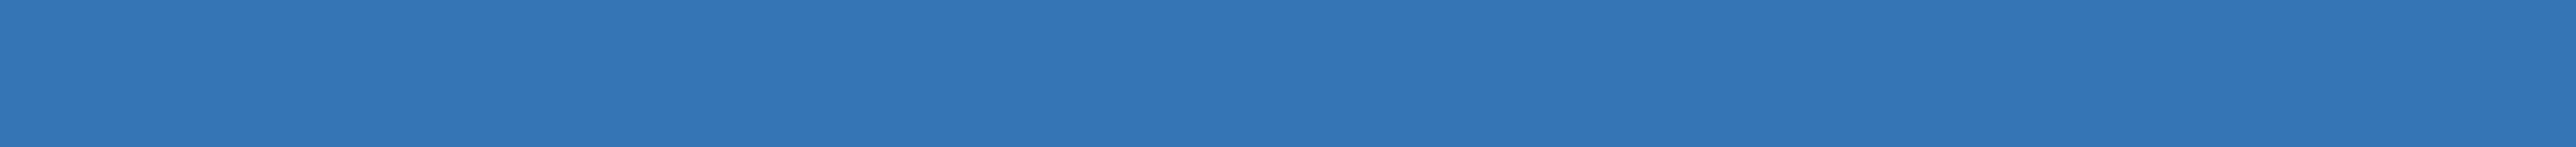

In [ ]:
imgscale = 0.3
def mydisplay(img):
  height = img.height
  width = img.width
#  resized_img = cv2.resize(img,(int(width*imgscale), int(height*imgscale)))
  display(img.resize(( int(width * imgscale), int(height * imgscale))))
#  display(resized_img)

In [ ]:
#@title #**manual generat images**

reset_folder('images')

# prompt
prompt = "kasumiarimura portrait" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}

# other setting
num_samples = 10
guidance_scale = 7.5
num_inference_steps = 50
height = 512
width = 512

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

In [ ]:
for i, img in enumerate(images):
    img.save('images/'+str(i).zfill(4)+'.jpg')
    mydisplay(img)

In [ ]:
#@title #**Download images**
from google.colab import files

if os.path.isfile('data.zip'):
  os.remove('data.zip')

! zip -r data.zip images
files.download('data.zip')

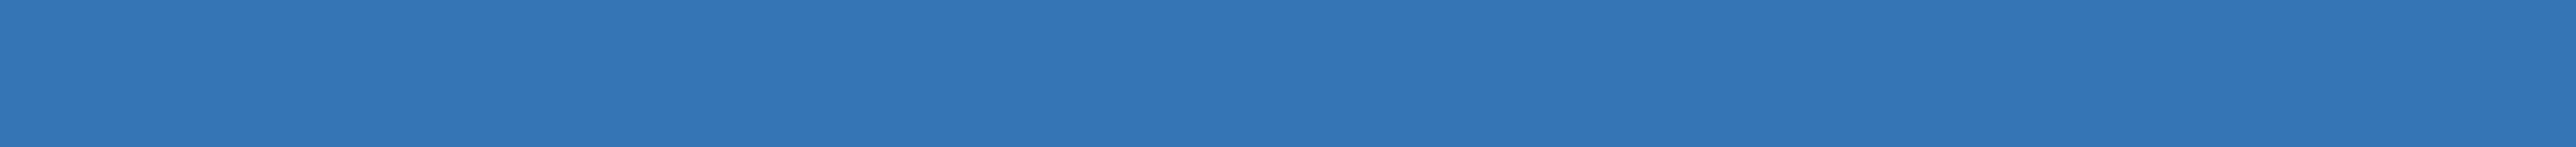

In [ ]:
#@title #**auto generat images**

# prompt bank
p0 = 'XXX profile picture by margaret keane, dynamic pose, intricate, futuristic, fantasy, elegant, by stanley artgerm lau, greg rutkowski, thomas kindkade, alphonse mucha, loish, norman rockwell'
p1 = 'Realistic detailed face portrait of a beautiful futuristic italian renaissance queen in opulent alien glass armor by alphonse mucha, XXX, ayami kojima, amano, greg hildebrandt, and mark brooks, female, feminine, art nouveau, ornate italian renaissance cyberpunk, iridescent venetian blown glass, neo - gothic, gothic, character concept design'
p2 = 'Photo of a gorgeous XXX in the style of stefan kostic, realistic, sharp focus, 8 k high definition, insanely detailed, intricate, elegant, art by david cronenberg and stanley lau and artgerm'
p3 = 'Photo of a gorgeous female in the style of stefan kostic, XXX, realistic, half body shot, sharp focus, 8 k high definition, insanely detailed, intricate, elegant, art by stanley lau and artgerm, extreme blur cherry blossoms background'
p4 = 'God and goddess, XXX, white hair, long hair, gorgeous, amazing, elegant, intricate, highly detailed, digital painting, artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha'
p5 = 'Portrait of a military engineer woman with short white hair, XXX, wearing overalls, medium shot, portrait, concept art, natural lighting, illustration, full color, highly detailed, photorealistic, by greg rutkowski, artstation'
bank = [p0, p1, p2, p3, p4, p5]

reset_folder('images')

# prompt
name = INSTANCE+' '+CLASS
prompt_bank_No = 0 #@param {type:"slider", min:0, max:5, step:1}
incantation = bank[prompt_bank_No]
prompt = incantation.replace('XXX', name)
print('prompt = ', prompt)
negative_prompt = ""

# other setting
num_samples = 10
guidance_scale = 7.5
num_inference_steps = 50
height = 512
width = 512

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for i, img in enumerate(images):
    img.save('images/'+str(i).zfill(4)+'.jpg')
    mydisplay(img)

In [ ]:
#@title #**Download images**
from google.colab import files

if os.path.isfile('data.zip'):
  os.remove('data.zip')

! zip -r data.zip images
files.download('data.zip')